In [ ]:
import requests
import csv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import schedule
import time

def get_trading_data(stockcode):
    current_date = datetime.now()
    start_date = current_date - timedelta(days=30)
    start_date_str = start_date.strftime('%d/%m/%Y')

    url = 'https://finance.vietstock.vn/data/gettradingresult'

    headers = {
        'Host': 'finance.vietstock.vn',
        'Cookie': 'language=vi-VN; Theme=Light; _pbjs_userid_consent_data=3524755945110770; _ga_EXMM0DKVEX=GS1.1.1703145769.7.1.1703146102.59.0.0; _ga=GA1.2.1214440855.1702969900; isShowLogin=true; dable_uid=undefined; AnonymousNotification=; _gid=GA1.2.1021456504.1702969902; __gads=ID=6a033cef9391c91c:T=1702969902:RT=1703146104:S=ALNI_MYzdS6dPNGfckZ4OaQtChqHoXPncw; __gpi=UID=00000cb6097d797e:T=1702969902:RT=1703146104:S=ALNI_MZcM5VnjaxQIehzhw9mpNHSJMViBA; cto_bundle=sjP2NV8xbjdkWEV4WjlGJTJGQWpRbmI0OUk2Q2xYZEhtTW1MZ21LcHdqQmpVUWI3NkZJNnJTRTVGUWZocFFheG03S21wUm9IR3lzYm5RQnNrdnBpTnV2ZDVsayUyQldVTFBRMWo1N2l3VDJkdHJOdXprOGJEVzBXZThDTHd5RWpvY2VNdzMlMkZwMWlrTGNzZlE1RnJ1c013czJ5ZVB0WEElM0QlM0Q; cto_bidid=tBZe6181clRZTkh1TUVhbWVxZlR4UFZ4U0cyMGlXVFNES3ZINTNvQ3huQnJOYVpSMzk3SEFNcHROV2dmcDhmQmZENEJmT0ltUzgxV0dyTnYzZVhuM0d2bjdiOUk3RzdGdkFjVGhja0UyNnpXOFdkZyUzRA; cto_dna_bundle=xwZ0SF8xbjdkWEV4WjlGJTJGQWpRbmI0OUk2Q2tkWjlMZEd5dER3c3VteXh2JTJCeHBkN0p1RWZyTlZzOEdiUU02aWtCNDJJMFFzeGtUQktYV3haMkNMR2hLU0ltV0ElM0QlM0Q; ASP.NET_SessionId=kxqfhim3w1m1xc50xnxsnj5k; __RequestVerificationToken=feSyicPujrXC7o04c_qni_DuDxv91ghjnlZo3Zb0wSorUggkxWuIeZLtcjLAaeQdTU4S7ZY8i0s3tALkj8DmfplRWg-hWH3Qcxn8MAmziko1; finance_viewedstock=HPG',
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/115.0',
    }

    data = {
        'Code': stockcode,
        'OrderBy': '',
        'OrderDirection': 'desc',
        'PageIndex': '1',
        'PageSize': '30',
        'FromDate': start_date_str,
        'ToDate': current_date.strftime('%d/%m/%Y'),  # Chuyển đổi thành chuỗi ngày tháng
        'ExportType': 'default',
        'Cols': 'TKLGD,TGTGD,VHTT,TGG,DC,TGPTG,KLGDKL,GTGDKL,OpenPrice,HighPrice,LowPrice',
        'ExchangeID': '1',
        '__RequestVerificationToken': 'WcpGXmYqtiiNjIcvN25UeW53XDTWYW6A1dS_33XTuMnj56BKNmdRvJEOPzWvKm_E-VcolXbJRaFELvsVxMEm1DyILQX_X0fivTP0dQxW62U1'
    }

    try:
        response = requests.post(url, headers=headers, data=data)
        response.raise_for_status()
        response_json = response.json()
    except requests.exceptions.RequestException as e:
        print(f"Yêu cầu HTTP thất bại: {e}")
        return None, None
    except ValueError as e:
        print(f"Không thể giải mã JSON: {e}")
        return None, None

    #print("Nội dung phản hồi:")
    #print(response.text)

    return response, response_json

def save_trading_data_to_csv(response_json, output_filepath):
    existing_dates = set()

    # Đọc các ngày đã có trong file CSV
    try:
        with open(output_filepath, 'r') as csvfile:
            csv_reader = csv.DictReader(csvfile)
            for row in csv_reader:
                existing_dates.add(row['Date'])
    except FileNotFoundError:
        pass  # Nếu file không tồn tại, bỏ qua

    if "Data" in response_json and len(response_json["Data"]) > 0:
        with open(output_filepath, 'a', newline='') as csvfile:
            fieldnames = ['Date', 'Price', 'Open', 'High', 'Low']
            csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            if csvfile.tell() == 0:
                csv_writer.writeheader()  # Ghi header nếu file rỗng

            for i in range(len(response_json["Data"])):
                open_price = str(response_json["Data"][i].get("OpenPrice", "N/A"))
                high_price = str(response_json["Data"][i].get("HighestPrice", "N/A"))
                low_price = str(response_json["Data"][i].get("LowestPrice", "N/A"))
                close_price = str(response_json["Data"][i]["ClosePrice"])
                trading_date_str = response_json["Data"][i]["TradingDate"]

                # Chuyển đổi timestamp
                try:
                    timestamp_ms = int(trading_date_str[6:-2])
                    trading_date_iso = datetime.utcfromtimestamp(timestamp_ms / 1000).strftime('%d/%m/%Y')
                except ValueError as e:
                    print(f"Không thể chuyển đổi timestamp: {e}")
                    trading_date_iso = "N/A"

                # Kiểm tra nếu ngày giao dịch đã tồn tại trong file CSV
                if trading_date_iso not in existing_dates:
                    csv_writer.writerow({ 'Date': trading_date_iso,
                                         'Price': close_price, 
                                         'Open': open_price, 
                                         'High': high_price,
                                         'Low': low_price })
                    print(f"{trading_date_iso}: Open: {open_price}, High: {high_price}, Low: {low_price}, Close: {close_price}")
                else:
                    print(f"Ngày {trading_date_iso} đã tồn tại trong file, bỏ qua.")

        print(f"Dữ liệu đã được lưu vào {output_filepath}")
    else:
        print(f"Không tìm thấy dữ liệu giao dịch cho mã chứng khoán ")


def job():
    stockcode_input = 'VCB'  # Bạn có thể thay đổi mã chứng khoán tại đây
    output_file_path = r"D:\SIC-BD1\Result\VCB Historical Data.csv"

    response, response_json = get_trading_data(stockcode_input)
    date = []
    open_price = []
    high_price = []
    low_price = []
    close_price = []

    if response_json and "Data" in response_json and len(response_json["Data"]) > 0:
        for i in range(len(response_json["Data"])):
            close_price_str = str(response_json["Data"][i]["ClosePrice"])
            trading_date_str = response_json["Data"][i]["TradingDate"]
            open_price_str = str(response_json["Data"][i].get("OpenPrice", "N/A"))
            high_price_str = str(response_json["Data"][i].get("HighestPrice", "N/A"))
            low_price_str = str(response_json["Data"][i].get("LowestPrice", "N/A"))

            try:
                timestamp_ms = int(trading_date_str[6:-2])
                trading_date_iso = datetime.utcfromtimestamp(timestamp_ms / 1000).strftime('%d/%m/%Y')
            except ValueError as e:
                print(f"Không thể chuyển đổi timestamp: {e}")
                trading_date_iso = "N/A"

            date.append(trading_date_iso)
            open_price.append(open_price_str)
            high_price.append(high_price_str)
            low_price.append(low_price_str)
            close_price.append(close_price_str)

        save_trading_data_to_csv(response_json, output_file_path)
    else:
        print(f"Không có dữ liệu giao dịch cho mã chứng khoán {stockcode_input}")

# Lên lịch chạy công việc mỗi ngày vào một giờ nhất định, ví dụ 9:00 sáng
schedule.every(1).minutes.do(job)

while True:
    schedule.run_pending()
    time.sleep(60)  # Kiểm tra lịch trình mỗi phút


Ngày 12/12/2024 đã tồn tại trong file, bỏ qua.
Ngày 11/12/2024 đã tồn tại trong file, bỏ qua.
Ngày 10/12/2024 đã tồn tại trong file, bỏ qua.
Ngày 09/12/2024 đã tồn tại trong file, bỏ qua.
Ngày 08/12/2024 đã tồn tại trong file, bỏ qua.
Ngày 05/12/2024 đã tồn tại trong file, bỏ qua.
Ngày 04/12/2024 đã tồn tại trong file, bỏ qua.
Ngày 03/12/2024 đã tồn tại trong file, bỏ qua.
Ngày 02/12/2024 đã tồn tại trong file, bỏ qua.
Ngày 01/12/2024 đã tồn tại trong file, bỏ qua.
Ngày 28/11/2024 đã tồn tại trong file, bỏ qua.
Ngày 27/11/2024 đã tồn tại trong file, bỏ qua.
Ngày 26/11/2024 đã tồn tại trong file, bỏ qua.
Ngày 25/11/2024 đã tồn tại trong file, bỏ qua.
Ngày 24/11/2024 đã tồn tại trong file, bỏ qua.
Ngày 21/11/2024 đã tồn tại trong file, bỏ qua.
Ngày 20/11/2024 đã tồn tại trong file, bỏ qua.
Ngày 19/11/2024 đã tồn tại trong file, bỏ qua.
Ngày 18/11/2024 đã tồn tại trong file, bỏ qua.
Ngày 17/11/2024 đã tồn tại trong file, bỏ qua.
Ngày 14/11/2024 đã tồn tại trong file, bỏ qua.
Dữ liệu đã đư

12/12/2024: Open: 93200, High: 93600, Low: 92900, Close: 93100
11/12/2024: Open: 93500, High: 94400, Low: 93500, Close: 93500
10/12/2024: Open: 94500, High: 94800, Low: 93200, Close: 93300
09/12/2024: Open: 95300, High: 95300, Low: 94500, Close: 94500
08/12/2024: Open: 94200, High: 95300, Low: 93900, Close: 95300
05/12/2024: Open: 94000, High: 95300, Low: 93900, Close: 94200
04/12/2024: Open: 93000, High: 94600, Low: 93000, Close: 94000
03/12/2024: Open: 92800, High: 93900, Low: 92500, Close: 93500
02/12/2024: Open: 94400, High: 94400, Low: 92600, Close: 93000
01/12/2024: Open: 94900, High: 95100, Low: 93900, Close: 94200
28/11/2024: Open: 92600, High: 93300, Low: 92500, Close: 93300
27/11/2024: Open: 93100, High: 93500, Low: 92500, Close: 92600
26/11/2024: Open: 92300, High: 93200, Low: 92300, Close: 92700
25/11/2024: Open: 91400, High: 92900, Low: 91400, Close: 92400
24/11/2024: Open: 90900, High: 92200, Low: 90900, Close: 91300
21/11/2024: Open: 91000, High: 91300, Low: 90600, Close

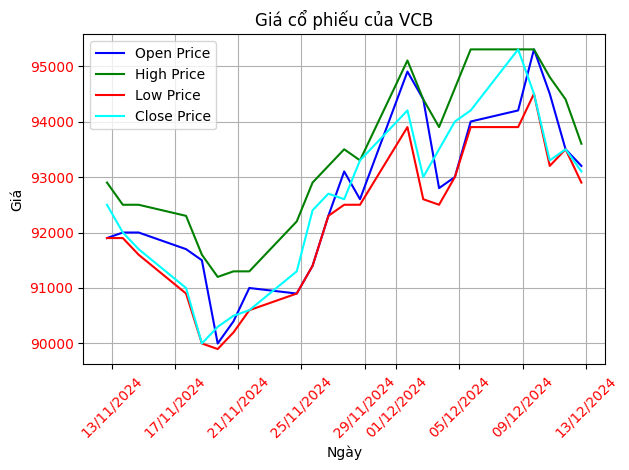

In [ ]:
import requests
import csv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import schedule
import time
import os

def get_trading_data(stockcode):
    current_date = datetime.now()
    start_date = current_date - timedelta(days=30)
    start_date_str = start_date.strftime('%d/%m/%Y')

    url = 'https://finance.vietstock.vn/data/gettradingresult'

    headers = {
        'Host': 'finance.vietstock.vn',
        'Cookie': 'language=vi-VN; Theme=Light; _pbjs_userid_consent_data=3524755945110770; _ga_EXMM0DKVEX=GS1.1.1703145769.7.1.1703146102.59.0.0; _ga=GA1.2.1214440855.1702969900; isShowLogin=true; dable_uid=undefined; AnonymousNotification=; _gid=GA1.2.1021456504.1702969902; __gads=ID=6a033cef9391c91c:T=1702969902:RT=1703146104:S=ALNI_MYzdS6dPNGfckZ4OaQtChqHoXPncw; __gpi=UID=00000cb6097d797e:T=1702969902:RT=1703146104:S=ALNI_MZcM5VnjaxQIehzhw9mpNHSJMViBA; cto_bundle=sjP2NV8xbjdkWEV4WjlGJTJGQWpRbmI0OUk2Q2xYZEhtTW1MZ21LcHdqQmpVUWI3NkZJNnJTRTVGUWZocFFheG03S21wUm9IR3lzYm5RQnNrdnBpTnV2ZDVsayUyQldVTFBRMWo1N2l3VDJkdHJOdXprOGJEVzBXZThDTHd5RWpvY2VNdzMlMkZwMWlrTGNzZlE1RnJ1c013czJ5ZVB0WEElM0QlM0Q; cto_bidid=tBZe6181clRZTkh1TUVhbWVxZlR4UFZ4U0cyMGlXVFNES3ZINTNvQ3huQnJOYVpSMzk3SEFNcHROV2dmcDhmQmZENEJmT0ltUzgxV0dyTnYzZVhuM0d2bjdiOUk3RzdGdkFjVGhja0UyNnpXOFdkZyUzRA; cto_dna_bundle=xwZ0SF8xbjdkWEV4WjlGJTJGQWpRbmI0OUk2Q2tkWjlMZEd5dER3c3VteXh2JTJCeHBkN0p1RWZyTlZzOEdiUU02aWtCNDJJMFFzeGtUQktYV3haMkNMR2hLU0ltV0ElM0QlM0Q; ASP.NET_SessionId=kxqfhim3w1m1xc50xnxsnj5k; __RequestVerificationToken=feSyicPujrXC7o04c_qni_DuDxv91ghjnlZo3Zb0wSorUggkxWuIeZLtcjLAaeQdTU4S7ZY8i0s3tALkj8DmfplRWg-hWH3Qcxn8MAmziko1; finance_viewedstock=HPG',
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/115.0',
    }

    data = {
        'Code': stockcode,
        'OrderBy': '',
        'OrderDirection': 'desc',
        'PageIndex': '1',
        'PageSize': '30',
        'FromDate': start_date_str,
        'ToDate': current_date.strftime('%d/%m/%Y'),  # Chuyển đổi thành chuỗi ngày tháng
        'ExportType': 'default',
        'Cols': 'TKLGD,TGTGD,VHTT,TGG,DC,TGPTG,KLGDKL,GTGDKL,OpenPrice,HighPrice,LowPrice',
        'ExchangeID': '1',
        '__RequestVerificationToken': 'WcpGXmYqtiiNjIcvN25UeW53XDTWYW6A1dS_33XTuMnj56BKNmdRvJEOPzWvKm_E-VcolXbJRaFELvsVxMEm1DyILQX_X0fivTP0dQxW62U1'
    }

    try:
        response = requests.post(url, headers=headers, data=data)
        response.raise_for_status()
        response_json = response.json()
    except requests.exceptions.RequestException as e:
        print(f"Yêu cầu HTTP thất bại: {e}")
        return None, None
    except ValueError as e:
        print(f"Không thể giải mã JSON: {e}")
        return None, None

    return response, response_json

def save_trading_data_to_csv(response_json, output_filepath):
    if "Data" in response_json and len(response_json["Data"]) > 0:
        file_exists = os.path.isfile(output_filepath)
        with open(output_filepath, 'a', newline='') as csvfile:
            fieldnames = ['StockCode', 'Trading Date', 'Open Price', 'High Price', 'Low Price', 'Close Price']
            csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            # Chỉ viết tiêu đề nếu file không tồn tại
            if not file_exists:
                csv_writer.writeheader()
            
            for i in range(len(response_json["Data"])):
                stockcode = response_json["Data"][i]["StockCode"]
                open_price = str(response_json["Data"][i].get("OpenPrice", "N/A"))
                high_price = str(response_json["Data"][i].get("HighestPrice", "N/A"))
                low_price = str(response_json["Data"][i].get("LowestPrice", "N/A"))
                close_price = str(response_json["Data"][i]["ClosePrice"])
                trading_date_str = response_json["Data"][i]["TradingDate"]

                try:
                    timestamp_ms = int(trading_date_str[6:-2])
                    trading_date_iso = datetime.utcfromtimestamp(timestamp_ms / 1000).strftime('%d/%m/%Y')
                except ValueError as e:
                    print(f"Không thể chuyển đổi timestamp: {e}")
                    trading_date_iso = "N/A"

                csv_writer.writerow({'StockCode': stockcode, 'Trading Date': trading_date_iso,
                                     'Open Price': open_price, 'High Price': high_price,
                                     'Low Price': low_price, 'Close Price': close_price})

                print(f"{trading_date_iso}: Open: {open_price}, High: {high_price}, Low: {low_price}, Close: {close_price}")

        print(f"Dữ liệu đã được lưu vào {output_filepath}")
    else:
        print(f"Không tìm thấy dữ liệu giao dịch cho mã chứng khoán {stockcode}")

def plot_trading_data(stockcode, date, open_price, high_price, low_price, close_price):
    if date and open_price and high_price and low_price and close_price:
        fig, ax = plt.subplots()
        ax.plot_date(date, open_price, '-', color='blue', label='Open Price')
        ax.plot_date(date, high_price, '-', color='green', label='High Price')
        ax.plot_date(date, low_price, '-', color='red', label='Low Price')
        ax.plot_date(date, close_price, '-', color='cyan', label='Close Price')
        ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
        plt.xticks(rotation=45, color='red')
        plt.yticks(color='red')
        plt.title(f"Giá cổ phiếu của {stockcode}")
        plt.xlabel("Ngày")
        plt.ylabel("Giá")
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()

def job():
    stockcode_input = 'VCB'
    output_file_path = 'trading_data.csv'
    response, response_json = get_trading_data(stockcode_input)
    if response_json:
        save_trading_data_to_csv(response_json, output_file_path)
        date, open_price, high_price, low_price, close_price = [], [], [], [], []
        for data in response_json["Data"]:
            trading_date = datetime.utcfromtimestamp(int(data["TradingDate"][6:-2]) / 1000)
            date.append(trading_date)
            open_price.append(float(data.get("OpenPrice", 0)))
            high_price.append(float(data.get("HighestPrice", 0)))
            low_price.append(float(data.get("LowestPrice", 0)))
            close_price.append(float(data["ClosePrice"]))
        plot_trading_data(stockcode_input, date, open_price, high_price, low_price, close_price)

# Đặt lịch trình để chạy job() vào lúc 9:36 mỗi ngày
schedule.every(1).minutes.do(job)

while True:
    schedule.run_pending()
    time.sleep(60)  # Đợi 1 phút trước khi kiểm tra lại lịch trình
